# Pitch Types Clustering

## Chapter 1 Introduction
In this task, We will be working with about 700,000 pitches which are from N types of pitches such as fastball, curveball, and so on. Therefore, the goal of this task is to develop a framework which is capable of clustering the pitches based on their characteristics. Generally, we will apply basic exploratory data analysis and k-means clustering to this task.

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections  as mc
import math
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import TruncatedSVD

In [64]:
# Load the data
data = pd.read_csv('candex_pitch_data.csv', index_col=0, low_memory=False)

## Chapter 2 Exploratory Data Analysis
### 2.1 Variable Selection
Since we will only use pysical characteristics of the pitch in the clustering, variables related to the game situation and the hitters will be ignored. After understanding the data glossary, we decide to use the variables including `RelSide`, `RelHeight`, `Extension`, `ReleaseSpeed`, `HorzBreak`, `VertBreak`, `Px`, and `Pz`. 

First two variables `RelSide` and `RelHeight` represent release point of the pitch. `Extension` represent distance from the front of the rubber to the release point of the pitch. `ReleaseSpeed` reprents speed of the pitch at release. `HorzBreak` and `VertBreak` represent movement of the pitch relative to the average fastball. Last two variables `Px` and `Pz` represent location of the pitch when it crosses home plate. We believe these eight variables are most approprate for clustering the pitches since those variables represent pysical conditions of the pitches and
how the pitches are thrown pysically.

In [65]:
# Check the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 692855 entries, 1 to 692855
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   GameEventId      692855 non-null  object 
 1   PitcherId        692855 non-null  object 
 2   Balls            692855 non-null  int64  
 3   Strikes          692855 non-null  int64  
 4   PitcherThrowing  692855 non-null  object 
 5   RelSide          692854 non-null  float64
 6   RelHeight        692854 non-null  float64
 7   Extension        692855 non-null  float64
 8   ReleaseSpeed     692855 non-null  object 
 9   HorzBreak        692855 non-null  float64
 10  VertBreak        692855 non-null  float64
 11  Px               692855 non-null  float64
 12  Pz               692855 non-null  float64
 13  BatterId         692855 non-null  object 
 14  BatterHitting    692855 non-null  object 
 15  swing            692855 non-null  int64  
 16  Result           692855 non-null  obje

### 2.2 Unusual Value Detection
After choosing the variables based on our understanding of baseball, we will thoroughly deal with unusual values appropriately in this section.

Basically, we find two major problems. First, regarding variable `ReleaseSpeed`, the dtype is object instead of float64. As a result, we guess there might be some strings in `ReleaseSpeed`. After checking all the values in `ReleaseSpeed`, we find there are several typos where decimal point is replaced by comma. Second, regarding variables `RelSide` and `RelHeight`, there is one NaN value. 

In [86]:
# Select targeted variables and drop the NaN value
targeted_data = data[['GameEventId','PitcherThrowing','RelSide','RelHeight','Extension','ReleaseSpeed','HorzBreak','VertBreak','Px','Pz']].dropna()

In [ ]:
# Check problem about ReleaseSpeed
for i in range(data.shape[0]):
    try: 
        data["ReleaseSpeed"].iloc[i] = float(data["ReleaseSpeed"].iloc[i])
    except:
        print(data["ReleaseSpeed"].iloc[i])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


89,3853
91,5271
94,2186
70,7487
95,4011
92,3519
84,3941
97,557
83,1171
74,1098
95,4135
95,1606
92,414
85,8042
87,2174
95,593
84,1304


In [87]:
# Replace comma with decimal point
targeted_data.loc[:,"ReleaseSpeed"] = targeted_data["ReleaseSpeed"].apply(lambda x: float(x.replace(',','.')))

### 2.3 Opposite Values for Right-handed and Left-handed Pitchers
In order to cluster the pitches based on their characteristics, it's important to notice that measurements in the horizontal direction will have opposite values for right-handed and left-handed pitchers for the same type of pitch. 

Therefore, in this section, in order to show the importance, we will first display `RelSide` and `RelHeight` in two plots regarding right-handed and left-handed pitchers repectively. After that, we will multiply the values of `RelSide` and `HorzBreak` regarding left-handed pitchers by `-1`. Finally, after multiplying, we will again display `RelSide` and `RelHeight` in a plot.

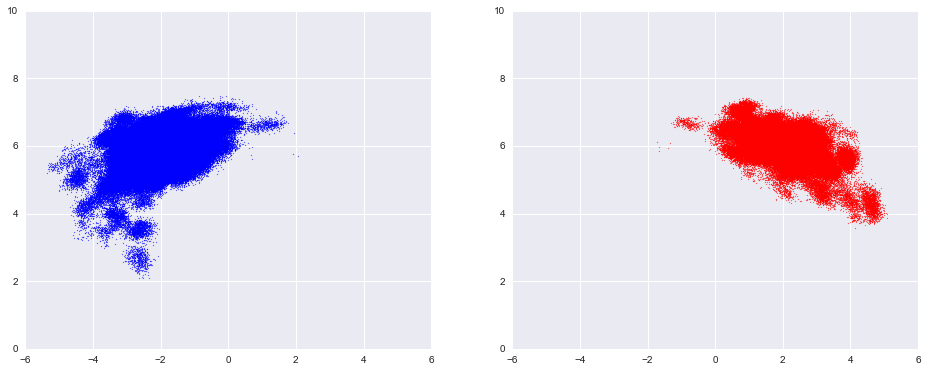

In [88]:
# Plot RelSide and RelHeight
x1 = targeted_data.loc[targeted_data['PitcherThrowing'] == 'R']['RelSide']
y1 = targeted_data.loc[targeted_data['PitcherThrowing'] == 'R']['RelHeight']
x2 = targeted_data.loc[targeted_data['PitcherThrowing'] == 'L']['RelSide']
y2 = targeted_data.loc[targeted_data['PitcherThrowing'] == 'L']['RelHeight']

fig, ax = plt.subplots(1,2,figsize=(16,8))
for ax1 in ax:
    ax1.axis('scaled')
    ax1.set_xlim([-6, 6])
    ax1.set_ylim([0, 10])
ax[0].scatter(x1, y1, color="blue", alpha=.5, s=1)
ax[1].scatter(x2, y2, color="red", alpha=.5, s=1)
plt.show()

In [89]:
# Multiplying
targeted_data.loc[(targeted_data['PitcherThrowing'] == 'L'), 'RelSide'] *= (-1)
targeted_data.loc[(targeted_data['PitcherThrowing'] == 'L'), 'HorzBreak'] *= (-1)

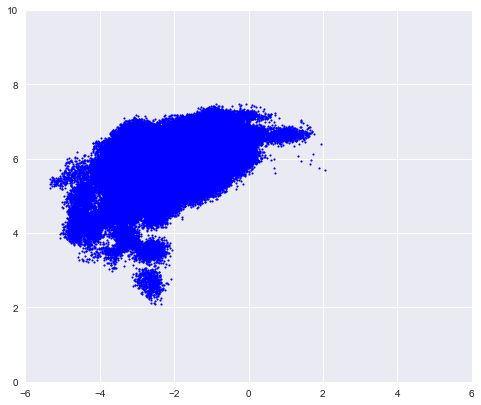

In [90]:
x1 = targeted_data['RelSide']
y1 = targeted_data['RelHeight']

fig, ax = plt.subplots(figsize=(8,8))
ax.axis('scaled')
ax.set_xlim([-6, 6])
ax.set_ylim([0, 10])
ax.scatter(x1, y1, color="blue", alpha=1, s=3)
plt.show()

### 2.4 Pitch Locations and Release spead
In this section, out of my curiousity, I first define the boundaries of the strike zone and display `Px` and `Py` in a plot with our defined strike zone. In my opinion, there is no siginificant outliers regarding the location of the pitches when they cross home plate. Besides, I display `ReleaseSpeed` in a histogram and I also believe all the values in `ReleaseSpeed` are reasonable.

In [91]:
# Define strike zone boundaries
srb = 1
slb = -1
stb = 3.5
sbb = 1.5 

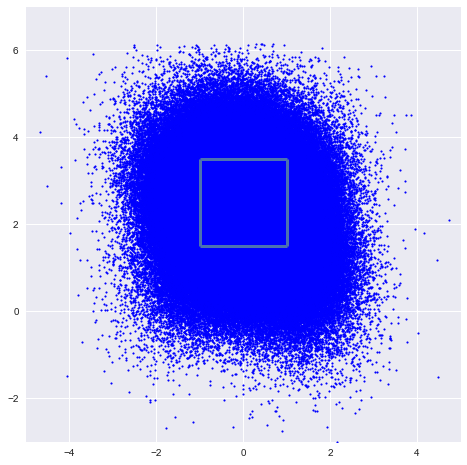

In [92]:
x1 = targeted_data['Px']
y1 = targeted_data['Pz']
s_lines = [[(slb, sbb), (srb, sbb)], [(srb, sbb), (srb, stb)], [(srb, stb), (slb, stb)], [(slb, stb), (slb, sbb)]]
s_lc = mc.LineCollection(s_lines, linewidths=3)

fig, ax = plt.subplots(figsize=(8,8))
ax.axis('scaled')
ax.set_xlim([-5, 5])
ax.set_ylim([-3, 7])
ax.add_collection(s_lc)
ax.scatter(x1, y1, color="blue", alpha=1, s=3)
plt.show()

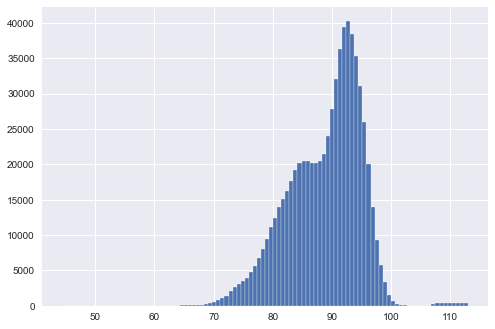

In [93]:
plt.hist(targeted_data['ReleaseSpeed'],bins=100)
plt.show()

### 2.5 Horizontal and Vetrical Movement
In this section, also out of my curiousity, I display `HorzBreak` and `VertBreak` in a plot. However, we find an serious issue about the plot. The values of `HorzBreak` which is greater 250 and smaller than -250 seem to be unreasonable. As a result, we will regard those values as the outliers. 

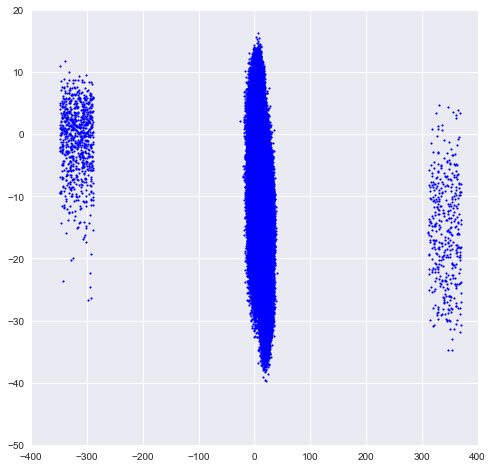

In [94]:
x1 = targeted_data['HorzBreak']
y1 = targeted_data['VertBreak']

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-400, 400])
ax.set_ylim([-50, 20])
ax.scatter(x1, y1, color="blue", alpha=1, s=3)
plt.show()

In [95]:
targeted_data = targeted_data.loc[(targeted_data['HorzBreak'] > -100) & (targeted_data['HorzBreak'] < 100)]

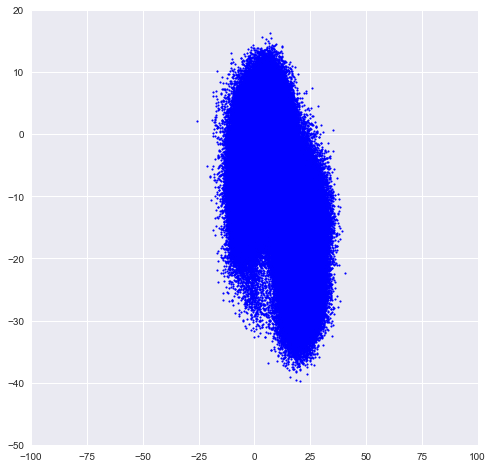

In [96]:
x1 = targeted_data['HorzBreak']
y1 = targeted_data['VertBreak']

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-100, 100])
ax.set_ylim([-50, 20])
ax.scatter(x1, y1, color="blue", alpha=1, s=3)
plt.show()

## Chapter 3 K-means Clustering
After preparing the targeted data in the previous chapter, we create a function to select optimal k value of k-means clustering using Davies–Bouldin socre in this chapter. From the plot of Davies–Bouldin socre, the optimal k value is equal to 2. However, it seems to be unreasonable that allt the pitches are from only two types of pitches. As a result, we might basically classify the pitches into 4 types of pitches. 

In [101]:
def plot_dbs(df, kmax=8): 
    dbs = []
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters=k, max_iter=600, algorithm='auto', random_state=0xCAFE).fit(df)
        labels = kmeans.labels_
        dbs.append(davies_bouldin_score(df, labels)) 

    plt.plot(range(2, kmax+1), dbs)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Davies Bouldin Method')
    plt.grid()
    plt.show()  

In [102]:
df = targeted_data[['RelSide','RelHeight','Extension','ReleaseSpeed','HorzBreak','VertBreak','Px','Pz']]

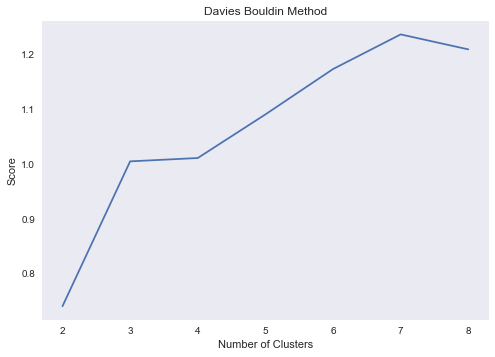

In [103]:
plot_dbs(df)                  

In [104]:
kmeans = KMeans(n_clusters=4, max_iter=600, algorithm='auto',random_state=0xCAFE).fit(df)
labels = kmeans.labels_

In [106]:
targeted_data['labels'] = pd.Series(labels)

<AxesSubplot:xlabel='0', ylabel='1'>

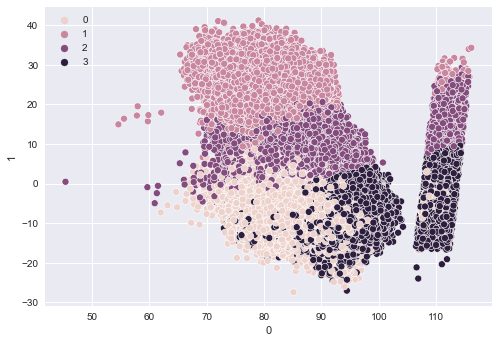

In [109]:
tSVDc = pd.DataFrame(TruncatedSVD(n_components=2, 
                                 algorithm='randomized', 
                                 n_iter=10, 
                                 random_state=0xCAFE).fit_transform(df))
sns.scatterplot(x=tSVDc.iloc[:,0], y=tSVDc.iloc[:,1], hue=kmeans.labels_)

In [119]:
kmc_df = pd.DataFrame(kmeans.labels_, index=df.index, columns=["KM_cluster"])
df = df.join(kmc_df)
df.groupby("KM_cluster").mean()

,RelSide,RelHeight,Extension,ReleaseSpeed,HorzBreak,VertBreak,Px,Pz
KM_cluster,,,,,,,,
0,-2.097278,5.813455,6.127985,89.134615,-3.701807,-5.612784,-0.138354,2.151368
1,-1.988324,5.955765,5.737747,79.201049,20.563315,-21.929180,0.065769,1.877593
2,-1.987512,5.947450,5.936818,86.019372,14.427606,-9.149982,0.234487,2.020712
3,-1.846112,6.051878,6.218332,93.368541,2.979312,2.431947,-0.008384,2.651285


## Chapter 4 Conclusions
Apparently, we didn't finish our work perfectly. However, we did provide a framework to deal with this kind of pitches clustering problem. Regarding label 3, `ReleaseSpeed` is higher and `HorzBreak` and `VertBreak` are smaller than other labels. Therefore, we believe they are fastballs.  Regarding label 1, `ReleaseSpeed` is smaller and `HorzBreak` and `VertBreak` are higher than other labels. Therefore, we believe they are curveballs. Regarding labels 0 and 2, `ReleaseSpeed` of lable 0 is slightly higher than label 2 while `HorzBreak` and `VertBreak` of lable 0 are smaller than label 2. As a result, we believe the pitches of lable 0 are changups and the pitches of label 2 are sliders.

## Chapter 5 Supplement
We believe label 1 (i.e curveball) is best for limiting offense since the probabilities of single, double, triple and homerun are lowest. Besides, its `LaunchAngle` is also lowest and its `ExitSpeed` is relatively lowest.

In [125]:
data = data.join(kmc_df)
data.groupby("KM_cluster").mean()

,Balls,Strikes,RelSide,RelHeight,Extension,HorzBreak,VertBreak,Px,Pz,swing,...,fieldingError,InPlay,inPlayOut,h1b,h2b,h3b,hr,ExitSpeed,LaunchAngle,Direction
KM_cluster,,,,,,,,,,,,,,,,,,,,,
0.0,0.938321,0.824062,-0.741574,5.813455,6.127985,-1.630847,-5.612784,-0.138354,2.151368,0.472790,...,0.002379,0.205019,0.135304,0.045525,0.013231,0.001195,0.008560,82.356020,11.104440,-2.040889
1.0,0.722613,1.001122,-0.864307,5.955765,5.737747,9.522489,-21.929180,0.065769,1.877593,0.407023,...,0.001560,0.149032,0.099683,0.031664,0.010120,0.000780,0.006241,80.521458,10.129860,0.605074
2.0,0.857845,0.989142,-1.033502,5.947450,5.936818,8.214019,-9.149982,0.234487,2.020712,0.489764,...,0.001976,0.168681,0.112235,0.035348,0.010737,0.000920,0.008641,80.415383,14.860539,7.921580
3.0,0.948773,0.847048,-0.876137,6.051878,6.218332,1.515641,2.431947,-0.008384,2.651285,0.467103,...,0.001403,0.169071,0.110605,0.035350,0.011977,0.001284,0.009636,82.682050,23.385975,7.784801
